# Daily Temperature Anomalies

- Load the temperature timeseries from each mooring
- Calculate daily temperature anomalies
- Plot the results
- Aiming for something similar to [ExampleCodeFromOHW22.ipynb](ExampleCodeFromOHW22.ipynb)


In [1]:
import sys

import pandas as pd

sys.path.insert(0, "../sa_upwelling")   # Allows using the files in the Python package
import utils

from matplotlib import pyplot as plt

## Load datasets

In [2]:
temp_timeseries = utils.load_all_timeseries()
list(temp_timeseries.keys())

Loading local hourly-timeseries data for mooring 'NRSKAI'.
Loading local hourly-timeseries data for mooring 'SAM8SG'.
Loading local hourly-timeseries data for mooring 'SAM5CB'.
Loading local hourly-timeseries data for mooring 'SAM2CP'.
Loading local hourly-timeseries data for mooring 'SAM6IS'.
Loading local hourly-timeseries data for mooring 'SAM3MS'.
Loading local hourly-timeseries data for mooring 'SAM7DS'.
Saved timeseries to ../Datasets/NRSKAI_TEMP_101-111m.csv
Saved timeseries to ../Datasets/SAM8SG_TEMP_38-48m.csv
Saved timeseries to ../Datasets/SAM5CB_TEMP_90-100m.csv
Saved timeseries to ../Datasets/SAM2CP_TEMP_90-100m.csv
Saved timeseries to ../Datasets/SAM6IS_TEMP_73-83m.csv
Saved timeseries to ../Datasets/SAM3MS_TEMP_158-168m.csv
Saved timeseries to ../Datasets/SAM7DS_TEMP_512-522m.csv


['NRSKAI', 'SAM8SG', 'SAM5CB', 'SAM2CP', 'SAM6IS', 'SAM3MS', 'SAM7DS']

## Do it step by step for NRSKAI

### Daily means

In [3]:
def plot_ts(df, col="TEMP"):
    "Plot the timeseries in column `col` of DataFrame or Series df"
    df.plot(y=col, figsize=[12, 6])

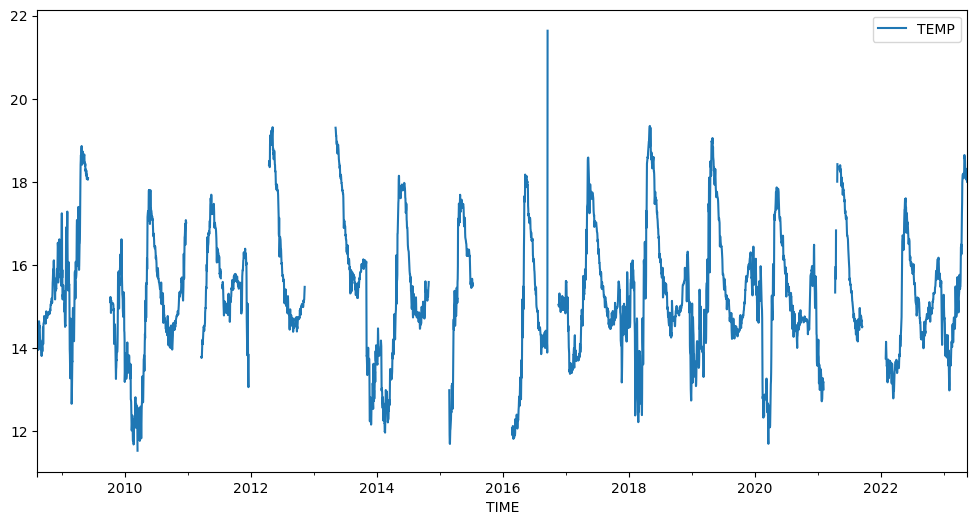

In [4]:
mooring = "NRSKAI"
df = temp_timeseries[mooring].set_index("TIME").drop(columns="DEPTH")

# Calculate daily means
temp_day = df.resample('D').mean()
temp_day["month"] = temp_day.index.month
plot_ts(temp_day)

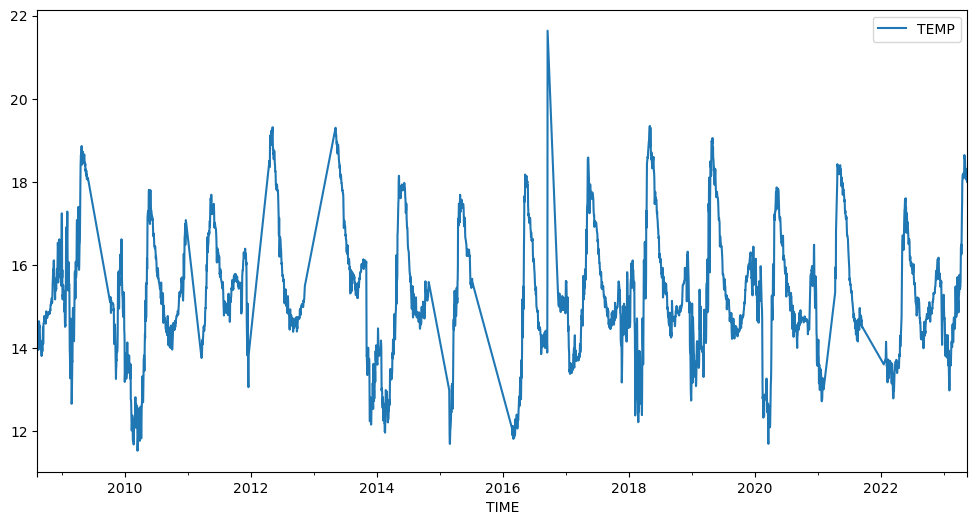

In [5]:
# interpolate missing data
temp_interp = temp_day.interpolate(method="time")
plot_ts(temp_interp)

### Monthly anomalies

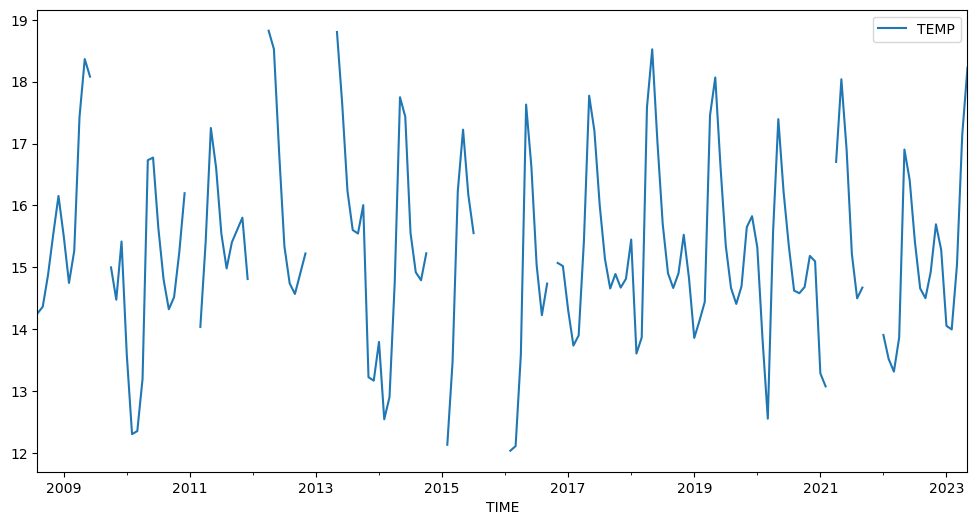

In [6]:
# Calculate monthly means
temp_mo = temp_day.resample('MS').mean()
temp_mo.month = temp_mo.month.astype(int)
plot_ts(temp_mo)

In [7]:
temp_mo

,TEMP,month
TIME,,
2008-08-01,14.256549,8
2008-09-01,14.363663,9
2008-10-01,14.872895,10
2008-11-01,15.532778,11
2008-12-01,16.153824,12
...,...,...
2023-01-01,14.055200,1
2023-02-01,13.997930,2
2023-03-01,15.039104,3


In [8]:
# Monthly climatology
clim_mo = temp_mo.groupby("month").TEMP.aggregate(tmean='mean', tstd='std', count='count')
clim_mo

,tmean,tstd,count
month,,,
1,14.308583,0.817286,10
2,13.307674,0.877199,12
3,13.606315,1.015640,12
4,15.941902,1.687524,14
5,17.814062,0.624208,15
6,16.896589,0.541472,14
7,15.533559,0.319512,13
8,14.772139,0.364588,13
9,14.710636,0.369202,13


In [9]:
# Calculate monthly anomalies
temp_mo["anom"] = temp_mo.TEMP - clim_mo.tmean.loc[temp_mo.month.values].values

### Daily anomalies

In [10]:
# Averaging window in days
navg = 28
nyear = 366  # number of days in the year

# Temperatures averaged by day of year
temp_day["doy"] = temp_day.index.dayofyear
t_fold = temp_day.groupby("doy").TEMP.mean()

# Duplicate January values at the end of the year so the rolling average works there too
t_jan = t_fold[:31]
t_jan.index = t_jan.index + nyear
t_fold = pd.concat([t_fold, t_jan])

# Now we can do the rolling average to get the climatology
clim_doy = t_fold.rolling(28, center=True).mean()
clim_doy.iloc[:navg//2] = clim_doy.iloc[nyear:nyear+navg//2]
clim_doy = clim_doy[:nyear]

<Axes: xlabel='doy', ylabel='TEMP'>

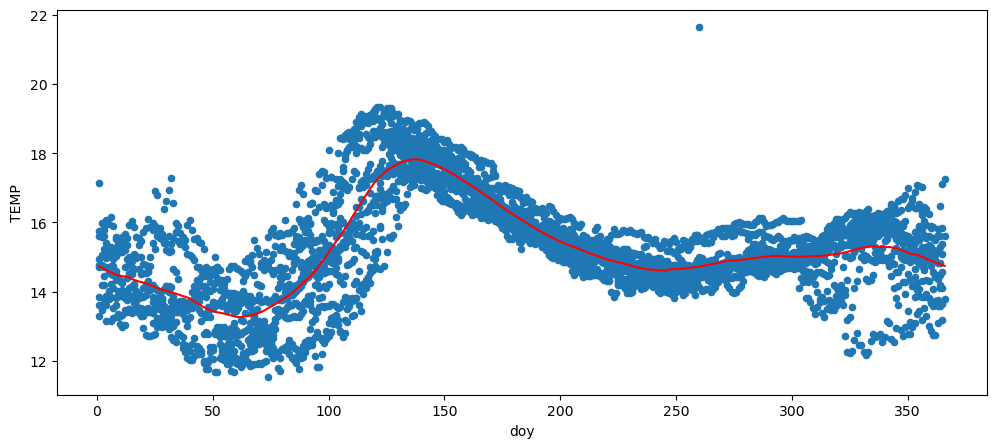

In [11]:
# and plot...
fig, ax = plt.subplots(figsize=(12,5))
temp_day.plot.scatter(x="doy", y="TEMP", ax=ax)
clim_doy.plot(ax=ax, c='r')

In [12]:
# Calculate anomalies
t_anom = temp_day.TEMP - clim_doy.loc[temp_day.doy.values].values
t_anom_mo = t_anom.resample("MS").mean()

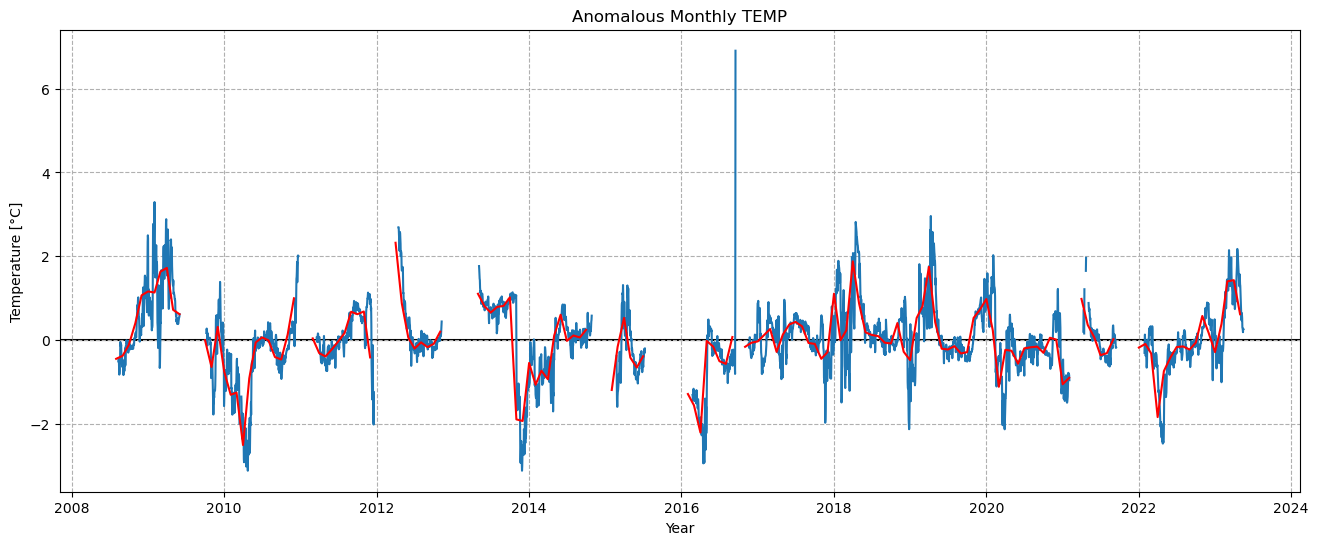

In [13]:
#create figure
plt.figure(figsize = [16, 6]) 
plt.plot(t_anom, zorder = 2)
plt.plot(t_anom_mo, zorder = 3, c = 'r')
plt.axhline(0, c = 'k', zorder = 1)
plt.xlabel('Year')
plt.ylabel('Temperature [°C]')
plt.title('Anomalous Monthly TEMP')
plt.grid(linestyle = '--')